In [ ]:
#Librerias generales
import numpy as np
import time
import os
import pickle
import itertools as it
import matplotlib.pyplot as plt

#Paquetes para manejo de datos
import pandas         as pd
import dask.dataframe as dd
from dask.diagnostics import ProgressBar

#Paquetes de nltk para preprocesamiento
import nltk
from   nltk.tokenize import TreebankWordTokenizer
from   nltk.stem     import PorterStemmer, WordNetLemmatizer
from   nltk.corpus   import stopwords

#Paquetes de sklearn
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection         import train_test_split
from sklearn.model_selection         import cross_val_score
from sklearn.naive_bayes             import MultinomialNB
from sklearn.datasets                import fetch_20newsgroups


newsgroups=fetch_20newsgroups(subset='all')
#newsgroups.targetNames
#newsgroups.target
df=pd.DataFrame([newsgroups.data,newsgroups.target]).T
df.columns = ['text', 'target']


In [ ]:
nltk.download('wordnet')
nltk.download('stopwords')

tokenizer  = TreebankWordTokenizer()
stemmer    = PorterStemmer()
lemmatizer = WordNetLemmatizer()

random_seed = 0
test_size   = 0.3
cross_sets  = 5

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
caching      = True

def get_nltk_cache_path(hp):
    cache_path = f'cache-{hp["isalpha"]}-{hp["lemm"]}-{hp["stemm"]}-{hp["remstopwords"]}'
    return cache_path

def get_sklearn_cache_path(hp):
    cache_path = f'cache-{hp["isalpha"]}-{hp["lemm"]}-{hp["stemm"]}-{hp["remstopwords"]}-{hp["tf_idf"]}-{hp["min_df"]}-{hp["max_df"]}'
    return cache_path

##Armado de las combinaciones de hiperparametros a probar

Se prueba el modelo con distintas combinaciones de hiperparametros
La elección de los min _df y max_df a probar se hizo viendo el histograma de dfs generado mas abajo donde se ve como variar entre algunos valores no tiene casi cambios sobre el volcabulario (por ejemplo max_df en [0,5 - 1]) y  algunos tienen mas efectos.

In [ ]:
hyperparameters_dict = {
    'isalpha'     :      [True, False],
    'lemm'        :      [True, False],
    'stemm'       :      [True, False],
    'remstopwords':      [True, False],
    'tf_idf'      :      [False, True],
    'min_df'      :      [0.005, 0.01, 0.05],
    'max_df'      :      [0.1, 0.15, 0.99],
    'alpha'       :      [0.01, 0.1, 1.0, 10.0],
}

# Generate all combination
combinations = list(it.product(*(hyperparameters_dict[Name] for Name in hyperparameters_dict.keys())))

#Saving combinations in a DataFrame
hyperparameters = pd.DataFrame(list(combinations),columns=hyperparameters_dict.keys())
print(hyperparameters) 

      isalpha   lemm  stemm  remstopwords  tf_idf  min_df  max_df  alpha
0        True   True   True          True   False   0.005    0.10   0.01
1        True   True   True          True   False   0.005    0.10   0.10
2        True   True   True          True   False   0.005    0.10   1.00
3        True   True   True          True   False   0.005    0.10  10.00
4        True   True   True          True   False   0.005    0.15   0.01
...       ...    ...    ...           ...     ...     ...     ...    ...
1147    False  False  False         False    True   0.050    0.15  10.00
1148    False  False  False         False    True   0.050    0.99   0.01
1149    False  False  False         False    True   0.050    0.99   0.10
1150    False  False  False         False    True   0.050    0.99   1.00
1151    False  False  False         False    True   0.050    0.99  10.00

[1152 rows x 8 columns]


##NLTK Preprocessing

In [ ]:
#Callback para el procesamiento paralelo de Dask
def nltk_preprocessor_callback(**kwargs):
    #Preprocesamiento con NLTK 
    def preprocessor(datapoint):
        raw_datapoint          = datapoint
        tokenized_datapoint    = tokenizer.tokenize(raw_datapoint)
        current_datapoint      = tokenized_datapoint
        
        if kwargs.setdefault('lemm', True):
            current_datapoint   = [lemmatizer.lemmatize(x,pos='v') for x in current_datapoint]
           
        if kwargs.setdefault('remstopwords', True):
            current_datapoint      = [x for x in current_datapoint if x not in stopwords.words('english')]

        if kwargs.setdefault('stemm', True):
            current_datapoint     = [stemmer.stem(x) for x in current_datapoint]
        
        #Salteamos dependiendo del hiperparámetro isalpha
        if kwargs.setdefault('isalpha', True):
            current_datapoint = [x for x in current_datapoint if x.isalpha()]
            
        return ' '.join(current_datapoint)

    return preprocessor

def run_nltk_preprocessor(hp, dataset=None):
    #print('NLTK Preprocessing...')
    to = time.time()
    cache_path = get_nltk_cache_path(hp)
    
    #Checkeamos si ya se corrió el preprocesamiento para esta combinación de hiperparámetros
    if not (os.path.exists(cache_path) and os.path.isfile(cache_path)):
        print('Cache miss: ', cache_path)


        preprocessor    = nltk_preprocessor_callback(isalpha=hp['isalpha'])
        ddataset        = dd.from_pandas(dataset, npartitions=os.cpu_count())
        with ProgressBar():
            dataset['text'] = ddataset['text'].map_partitions(lambda df: df.apply(preprocessor)). compute(scheduler='multiprocessing')
        
        #Guardamos en la cache este intento
        if caching is True:
            cache_path = get_nltk_cache_path(hp)
            with open(cache_path, 'wb') as fp:
                pickle.dump(dataset, fp)
        
    tf = time.time()
    #print('finished in', (int(tf-to)), 'seconds.')

In [ ]:
for idx,hyperParam in hyperparameters.iterrows():
    run_nltk_preprocessor(hyperParam, dataset=df )

#!zip -r /content/file.zip /content/Folder_To_Zip #zipeo todo lo cacheado para descargar

##SKlearn Preprocessing

In [ ]:
def run_sklearn_preprocessor(hp, dataset=None):
    print('sklearn preprocessing...')
    to = time.time()
    cache_path = get_sklearn_cache_path(hp)
    
    #Checkeamos si ya intentamos con esta combinación
    if not (os.path.exists(cache_path) and os.path.isfile(cache_path)):    
        print('Cache miss: ', cache_path)   
        
        if caching is True:
            cache_path = get_nltk_cache_path(hp)
            with open (cache_path, 'rb') as fp:
                dataset = pickle.load(fp)
        else:
            dataset = dataset.copy()

        #Corremos el vectorizer que corresponde, igual que en clase anterior
        V = (TfidfVectorizer if hp['tf_idf'] is True else CountVectorizer)(min_df=hp['min_df'], max_df=hp['max_df'])
        X = V.fit_transform(dataset['text']).toarray()
        Y = np.array([dataset['target'].values]).T
        D = np.hstack((X, Y))

        np.random.seed(seed=random_seed)
        np.random.shuffle(D)

        if caching is True:
            cache_path = get_sklearn_cache_path(hp)
            with open(cache_path, 'wb') as fp:
                pickle.dump(D, fp)

    tf = time.time()
    #print('finished in', (int(tf-to)), 'seconds.')

### Análisis de max_df y min_df apropiados

Se generaron histogramas para todos los casos de preprosesamiento con NLTK (lemming, stemming,etc) pero no hubo cambios demasiado notorios como para afectar a la decisión de dfs. Se genera e imprime solo uno que ya que los demas no cambian mucho en forma.

In [ ]:
df_test_hyperparameter_dict = {
    'isalpha'     :      [True],
    'lemm'        :      [True],
    'stemm'       :      [True],
    'remstopwords':      [True],
    'tf_idf'      :      [True],
    #con estos valores veo casi todo el rango utilizable de dfs para max y min
    'min_df'      :      [0.0001],
    'max_df'      :      [0.99],
}

df_test_hyperparameter = pd.DataFrame.from_dict(df_test_hyperparameter_dict)
print(df_test_hyperparameter.iloc[0])
run_sklearn_preprocessor(df_test_hyperparameter.iloc[0])
with open (get_sklearn_cache_path(df_test_hyperparameter.iloc[0]), 'rb') as fp:
            dataset = pickle.load(fp)

dfs=[]
docNum=len(dataset)
dfs.append(np.count_nonzero(dataset, axis=0)/docNum)


Histograma de document frecuencies 



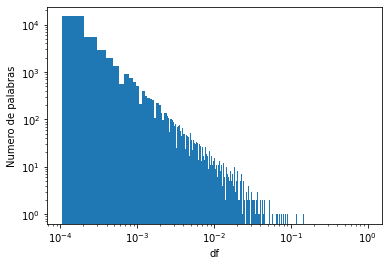

In [ ]:
def plotHistograma(dfs): 
    #binCentres = (binEdges[:-1] + binEdges[1:])/2
    plt.hist(dfs, bins = 10000)
    plt.xticks(ticks=[0.01, 0.1, 0.2 ,0.3 , 0.4, 0.6, 0.8, 1])#para plotear x lineal
    plt.yscale('log')
    plt.xscale('log')
    plt.xlabel('df')
    plt.ylabel('Numero de palabras')
    plt.show()

print(f'Histograma de document frecuencies \n')    
plotHistograma(dfs[0])
# En este histograma se ve claramente como la mayor parte de las palabras tiene 
# un df menor a 0.15 o 0.1
# Es por esto que la variacion de max_df para probar 
# es  [0.1 0.15 0.99] , para que cambie el comportamiento en las pruebas

# Se considero tomar valores menores a 0.005 para min_df 
# pero cada archivo cacheado de estos casos ocupa mas de 300MB 
# haciendo imposible probar todas las combinaciones con el hardware que se dispone
# Si no se cachearan la limitación estaria en la RAM disponible o el tiempo que toma correr el programa

#El plot se hace logaritmico para mayor claridad


Ejecuto el preprocesador de Sklearn con todos los hiperparametros

In [ ]:
print('Preprocessing dataset...')
for index, hp in hyperparameters.iterrows():
    print(index)
    print(hp.to_dict())
    run_sklearn_preprocessor(hp)

Preprocessing dataset...
0
{'isalpha': True, 'lemm': True, 'stemm': True, 'remstopwords': True, 'tf_idf': False, 'min_df': 0.005, 'max_df': 0.1, 'alpha': 0.01}
sklearn preprocessing...
Cache miss:  cache-True-True-True-True-False-0.005-0.1
1
{'isalpha': True, 'lemm': True, 'stemm': True, 'remstopwords': True, 'tf_idf': False, 'min_df': 0.005, 'max_df': 0.1, 'alpha': 0.1}
sklearn preprocessing...
2
{'isalpha': True, 'lemm': True, 'stemm': True, 'remstopwords': True, 'tf_idf': False, 'min_df': 0.005, 'max_df': 0.1, 'alpha': 1.0}
sklearn preprocessing...
3
{'isalpha': True, 'lemm': True, 'stemm': True, 'remstopwords': True, 'tf_idf': False, 'min_df': 0.005, 'max_df': 0.1, 'alpha': 10.0}
sklearn preprocessing...
4
{'isalpha': True, 'lemm': True, 'stemm': True, 'remstopwords': True, 'tf_idf': False, 'min_df': 0.005, 'max_df': 0.15, 'alpha': 0.01}
sklearn preprocessing...
Cache miss:  cache-True-True-True-True-False-0.005-0.15
5
{'isalpha': True, 'lemm': True, 'stemm': True, 'remstopwords': 

#Clasificador: Evaluar scores

In [ ]:

#Callback para el procesamiento paralelo de Dask
def score_callback(dataset=None):
    def score_classifier(hp):
        print(hp.to_dict())
        
        if caching is True:
            cache_path = get_sklearn_cache_path(hp)
            with open (cache_path, 'rb') as fp:
                D = pickle.load(fp)
        else:
            D = dataset.copy()

        X = D[:,:D.shape[1]-1]
        Y = D[:,D.shape[1]-1:].flatten()

        X_train, X_test, Y_train, Y_test = train_test_split(X,  Y.astype(int), test_size=test_size, shuffle=False)

        #Defino el clasificador
        clf = MultinomialNB(alpha=hp['alpha'], class_prior=None, fit_prior=False)
        
        #Obtengo el score
        scores = cross_val_score(clf, X_train, Y_train.astype(int), cv=cross_sets)

        hp['score'] = scores.mean()
        
        return hp
    return score_classifier

In [ ]:
print('Evaluating hyperparameters...')
to = time.time()
    
score_classifier = score_callback()
dhyperparameters = dd.from_pandas(hyperparameters.copy(), npartitions=os.cpu_count())
scores           = hyperparameters.apply(score_classifier, axis=1)

tf = time.time()
print('finished in', (int(tf-to)), 'seconds.')

Evaluating hyperparameters...
{'isalpha': True, 'lemm': True, 'stemm': True, 'remstopwords': True, 'tf_idf': False, 'min_df': 0.005, 'max_df': 0.1, 'alpha': 0.01}
{'isalpha': True, 'lemm': True, 'stemm': True, 'remstopwords': True, 'tf_idf': False, 'min_df': 0.005, 'max_df': 0.1, 'alpha': 0.01}
{'isalpha': True, 'lemm': True, 'stemm': True, 'remstopwords': True, 'tf_idf': False, 'min_df': 0.005, 'max_df': 0.1, 'alpha': 0.1}
{'isalpha': True, 'lemm': True, 'stemm': True, 'remstopwords': True, 'tf_idf': False, 'min_df': 0.005, 'max_df': 0.1, 'alpha': 1.0}
{'isalpha': True, 'lemm': True, 'stemm': True, 'remstopwords': True, 'tf_idf': False, 'min_df': 0.005, 'max_df': 0.1, 'alpha': 10.0}
{'isalpha': True, 'lemm': True, 'stemm': True, 'remstopwords': True, 'tf_idf': False, 'min_df': 0.005, 'max_df': 0.15, 'alpha': 0.01}
{'isalpha': True, 'lemm': True, 'stemm': True, 'remstopwords': True, 'tf_idf': False, 'min_df': 0.005, 'max_df': 0.15, 'alpha': 0.1}
{'isalpha': True, 'lemm': True, 'stemm':

In [ ]:
with pd.option_context('display.max_rows', None):  # more options can be specified also
    print(scores)

      isalpha   lemm  stemm  remstopwords  ...  min_df  max_df  alpha     score
0        True   True   True          True  ...   0.005    0.10   0.01  0.789721
1        True   True   True          True  ...   0.005    0.10   0.10  0.794042
2        True   True   True          True  ...   0.005    0.10   1.00  0.790479
3        True   True   True          True  ...   0.005    0.10  10.00  0.771908
4        True   True   True          True  ...   0.005    0.15   0.01  0.795558
5        True   True   True          True  ...   0.005    0.15   0.10  0.798590
6        True   True   True          True  ...   0.005    0.15   1.00  0.794269
7        True   True   True          True  ...   0.005    0.15  10.00  0.775925
8        True   True   True          True  ...   0.005    0.99   0.01  0.795255
9        True   True   True          True  ...   0.005    0.99   0.10  0.798287
10       True   True   True          True  ...   0.005    0.99   1.00  0.793891
11       True   True   True          Tru

In [ ]:
#La mejor combinación de hiperparámetros...
best_hp = scores.loc[scores['score'].idxmax()].drop(['score'])
print(f'El mejor conjunto de hiperparametros es: \n {best_hp.to_dict()}')
best_score=scores.loc[scores['score'].idxmax()].to_dict()['score']
print(f'\n Obtuvo el siguiente score: {best_score}')


El mejor conjunto de hiperparametros es: 
 {'isalpha': True, 'lemm': True, 'stemm': True, 'remstopwords': True, 'tf_idf': True, 'min_df': 0.005, 'max_df': 0.99, 'alpha': 0.1}

 Obtuvo el siguiente score: 0.8215588129420448


Viendo los resultados en validación se nota que los mejores se obtienen para el numero mas bajo de min df.
Teniendo en cuenta eso pruebo reducir min_df a 0.001.
Este valor se pudo probar en las combinaciones anteriores porque requiere demasiada memoria para almacenar todos los archivos cacheados ya que hay muchas palabras con bajos dfs.
Pruebo sobre la anterior combinacion de mejor resultado usar el nuevo min_df

In [ ]:
df_new_hyperparameter_dict = {
    'isalpha'     :      [True],
    'lemm'        :      [True],
    'stemm'       :      [True],
    'remstopwords':      [True],
    'tf_idf'      :      [True],
    'min_df'      :      [0.001],
    'max_df'      :      [0.99],
    'alpha'       :      [0.1]
}

hp_new= pd.DataFrame.from_dict(df_new_hyperparameter_dict).iloc[0]

cache_path = 'cache-True-True-True-True-True-0.001-0.99'
with open (cache_path, 'rb') as fp:
    D = pickle.load(fp)
print(f'La matriz que se tiene para el modelo es de tamaño{D.shape}\n')
print(cache_path)#Para este caso se genero el archivo en el codigo del histograma


X = D[:,:D.shape[1]-1]
Y = D[:,D.shape[1]-1:].flatten()

X_train, X_test, Y_train, Y_test = train_test_split(X, Y.astype(int), test_size=test_size, shuffle=False)


#Aca defino el clasificador
clf = MultinomialNB(alpha=hp_new['alpha'], class_prior=None, fit_prior=False)

#Obtengo el score
scores = cross_val_score(clf,X= X_train, y=Y_train.astype(int), cv=cross_sets)
print(f'Se prueba con los hiperparametros:\n {df_new_hyperparameter_dict}')
print(f'El score obtenido en esta prueba fue: {scores.mean()}')


(18846, 7852)
cache-True-True-True-True-True-0.001-0.99
Se prueba con los hiperparametros:
 {'isalpha': [True], 'lemm': [True], 'stemm': [True], 'remstopwords': [True], 'tf_idf': [True], 'min_df': [0.001], 'max_df': [0.99], 'alpha': [0.1]}
El score obtenido en esta prueba fue: 0.8553673954081786


###Clasificador: entrenamiento
Teniendo en cuenta los resultados anteriores lo apropiado sería probar las combinaciones una vez mas tomando min_df=0.001 como una posibilidad en todas y quizas descartar otras.
Sin embargo, como ya se dijo, eso no es posible con los recursos que se tienen. 
Entonces se usan los mejores hiperparametros que se consiguieron hasta el momento, que surgieron de la ultima prueba.


El modelo con menor min_df tiene un mayor numero de parametros. Los datos que tenemos indicarian que reducir el min_df mejora el accuracy, sin embargo hay que tener en cuenta que un modelo de demasiadas palabras sufriría overfitting.


In [ ]:
print('Training model with best hyperparameters...')

#Me quedo con la mejor combinación de hiperparámetros.
#best_hp = scores.loc[scores['score'].idxmax()].drop(['score'])
print(df_new_hyperparameter_dict)

if caching is True:
    cache_path = get_sklearn_cache_path(hp_new)
    with open (cache_path, 'rb') as fp:
        D = pickle.load(fp)
else:
    D = dataset.copy()

X = D[:,:D.shape[1]-1]
Y = D[:,D.shape[1]-1:].flatten()
print(X.shape)
#Separamos el dataset para train y validation
X_train, X_test, Y_train, Y_test = train_test_split(X, Y.astype(int), test_size=test_size, shuffle=False)

#Creamos el clasificador para los mejores hiperparámetros
clf = MultinomialNB(alpha=hp_new['alpha'], class_prior=None, fit_prior=False)

#Entrenamos el modelo
clf.fit(X_train.copy(),  Y_train.copy())

Training model with best hyperparameters...
{'isalpha': [True], 'lemm': [True], 'stemm': [True], 'remstopwords': [True], 'tf_idf': [True], 'min_df': [0.001], 'max_df': [0.99], 'alpha': [0.1]}
(18846, 7851)


MultinomialNB(alpha=0.1, class_prior=None, fit_prior=False)

In [ ]:
print('Evaluating best model...')
    
if caching is True:
    cache_path = get_sklearn_cache_path(hp_new)
    with open (cache_path, 'rb') as fp:
        D = pickle.load(fp)
else:
    D = dataset.copy()

X = D[:,:D.shape[1]-1]
Y = D[:,D.shape[1]-1:].flatten()

#Separo el set para train y test
X_train, X_test, Y_train, Y_test = train_test_split(X, Y.astype(int), test_size=test_size, shuffle=False)
    
#Vemos el score final del modelo para test
score = clf.score(X_test, Y_test)
print("accuracy: {:.4}%".format(score*100))

Evaluating best model...
accuracy: 86.12%


##Conclusión
Se obtuvo un accuracy en test del 86% para la clasificación de articulos, que es un valor satisfactorio. 
Se tomaron muchas combinaciones de hiperparametros posibles. Probando con algunas combinaciones de hiperparametros para menores valores de min_df quizas se podrían haber obtenido resultados un poco mejores en validación y posteriormente en test. Sin embargo, hay un limite para cuantas palabras de pueden tener en el modelo sin tener overfitting.